In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import time, os
import dv_processing as dv
from PIL import Image
import numpy as np

In [3]:
def getRecordingDuration(record):
    if record.isEventStreamAvailable():
        start, end = record.getTimeRange()
        duration = end - start 
    
    return duration # divide by 1e6 to convert to seconds

def getSampleDuration(sample):
    start, end = sample.timestamps()[0], sample.timestamps()[-1]
    duration = end - start
    return duration

def getNumEvents(sample):
    num_events = sample.size()
    return num_events
    

In [4]:
subject = 1
letter = 'f'
AEDAT = f"../data/aedat/subject{subject}/{letter}.aedat4"
GIF = False

In [5]:
recording = dv.io.MonoCameraRecording(AEDAT)
record_duration = getRecordingDuration(recording)
print(f"Recording duration: {record_duration / 1e6} secs")

Recording duration: 81.728724 secs


In [7]:
batch_time = int(3e6) 
num_batches = record_duration // batch_time
t0, t1 = recording.getTimeRange()
print("Start timestamp:", t0)
print("End timestamp:", t1)

cols = ['batch', 't0', 't1', 'duration', 'num_events']
batches = pd.DataFrame(columns=cols)
start = t0
for i in range(num_batches):
    start, end = start, start + batch_time
    batch = recording.getEventsTimeRange(start, end)
    batch_duration = getSampleDuration(batch)
    batch_numEvents = getNumEvents(batch)

    data = pd.DataFrame({'batch': [i], 
            't0': [start], 
            't1': [end],
            'duration': [batch_duration],
            'num_events': [batch_numEvents]})

    batches = pd.concat([batches, data])
    start += batch_time

Start timestamp: 124288256
End timestamp: 206016980


In [8]:
batches

,batch,t0,t1,duration,num_events
0,0,124288256,127288256,2999999,275695
0,1,127288256,130288256,2999848,360538
0,2,130288256,133288256,2999945,323390
0,3,133288256,136288256,2999980,315518
0,4,136288256,139288256,2999948,317157
0,5,139288256,142288256,2999881,273026
0,6,142288256,145288256,2999976,279386
0,7,145288256,148288256,2999985,313677
0,8,148288256,151288256,2999994,315387
0,9,151288256,154288256,2999957,290194


Text(0, 0.5, 'Number of Events')

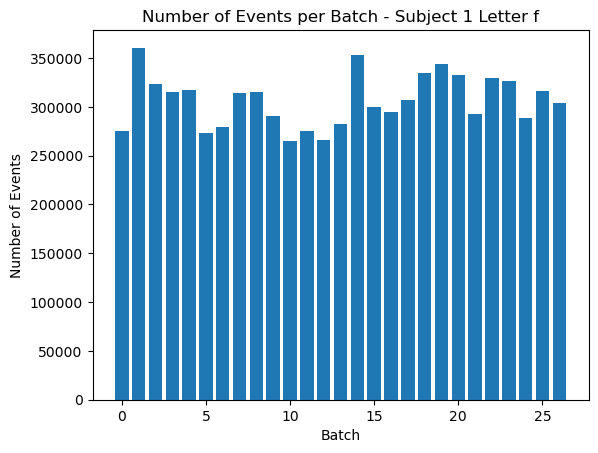

In [9]:
plt.bar(batches['batch'], batches['num_events'])
plt.title(f"Number of Events per Batch - Subject {subject} Letter {letter}")
plt.xlabel("Batch")
plt.ylabel("Number of Events")

In [10]:
# batch = recording.getEventsTimeRange(batches['t0'].iloc[0], batches['t1'].iloc[0])
df = pd.read_csv(f"../data/csv/subject{subject}/{letter}_events.csv")
num_events = batches['num_events'].iloc[0]
print(f"Number of events in Batch 0:", num_events)
batch0 = df.loc[:num_events]
batch0

Number of events in Batch 0: 275695


,Unnamed: 0,timestamp,x,y,polarity
0,0,124288256,96,57,0
1,1,124288260,96,59,0
2,2,124288267,139,64,1
3,3,124288270,127,67,1
4,4,124288274,114,69,0
...,...,...,...,...,...
275691,991,127288240,99,43,1
275692,992,127288254,75,46,0
275693,993,127288255,75,45,0
275694,994,127288255,90,45,0


In [22]:
t0s = np.array(list(batch0[batch0['Unnamed: 0'] == 0].index))
print("# of samples in batch:", len(t0s))

sample_freq = []
for i, t in enumerate(t0s):
    if i+1 < len(t0s):
        sample = batch0.iloc[:t0s[i+1]]
    else:
        sample = batch0.iloc[t0s[i]:]
    
    sample_freq.append(sample.size)

sample_freq = np.array(sample_freq)
print("# of samples in batch (frequency check):", len(sample_freq))

# of samples in batch: 297
# of samples in batch (frequency check): 297


Text(0.5, 1.0, '# of Events in Each Sample - Batch 0')

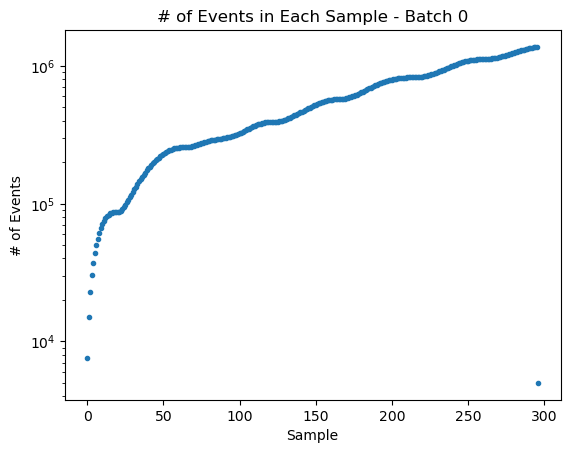

In [21]:
x = np.arange(len(sample_freq))
plt.scatter(x, sample_freq, marker='.')
plt.yscale('log')
plt.xlabel("Sample")
plt.ylabel("# of Events")
plt.title("# of Events in Each Sample - Batch 0")